In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import traceback
import datetime
from datetime import timedelta

# 데이터 분석 기본 라이브러리 관련
import os
import sys
import platform
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

# EDA 관련
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import missingno as msno

# 데이터 전처리 관련
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
tf.random.set_seed(123)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/서영')

In [4]:
# 삼성전자=pd.read_csv('./삼성전자.csv',encoding='cp949')
SK하이닉스=pd.read_csv('./SK하이닉스.csv',encoding='cp949')

In [5]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = SK하이닉스.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(SK하이닉스)),columns=['날짜', '종가'])
for i in range(0,len(data)):
    new_data['날짜'][i] = data['날짜'][i]
    new_data['종가'][i] = data['종가'][i]

#setting index
new_data.index = new_data.날짜
new_data.drop('날짜', axis=1, inplace=True)

In [ ]:
new_data.head()

,종가
날짜,
2000.01.04,25750
2000.01.05,23100
2000.01.06,21900
2000.01.07,21700
2000.01.10,21500


In [6]:
final_test = SK하이닉스[SK하이닉스.날짜.str[:7].apply(lambda x: x in ['2019.09', '2019.10', '2019.11', '2019.12'])]
test_start = final_test.index[0]
#test_last = test.index[-1]

dataset = new_data.values
#print(len(dataset[:test_start])*0.2)
train = dataset[0:test_start-970]
test = dataset[test_start-970:test_start]
print(train.shape, test.shape)

(3879, 1) (970, 1)


In [7]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train_1, y_train_1 = [], []
for i in range(20,len(train)):
    x_train_1.append(scaled_data[i-20:i,0])
    y_train_1.append(scaled_data[i,0])
x_train_1, y_train_1 = np.array(x_train_1), np.array(y_train_1)



x_train_1 = np.reshape(x_train_1, (x_train_1.shape[0],x_train_1.shape[1],1))
print(x_train_1.shape, y_train_1.shape)

(3859, 20, 1) (3859,)


In [8]:
from sklearn.model_selection import train_test_split
x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(x_train_1, y_train_1, test_size=0.2,shuffle=False)
print("x_train \t x_valid")
print(x_train_1.shape, x_valid_1.shape)

x_train 	 x_valid
(3087, 20, 1) (772, 20, 1)


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
# create and fit the LSTM network
model_1 = Sequential()
model_1.add(LSTM(units=16, return_sequences=False, input_shape=(x_train_1.shape[1],1)))
model_1.add(Dense(1))
model1_path=os.getcwd()
model_1.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename1 = os.path.join(model1_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename1, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model_1.fit(x_train_1, y_train_1, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid_1, y_valid_1), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
190/193 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 00001: val_loss improved from inf to 0.00027, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint.h5
193/193 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 2.7215e-04
Epoch 2/200
190/193 [============================>.] - ETA: 0s - loss: 2.2910e-04
Epoch 00002: val_loss improved from 0.00027 to 0.00021, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint.h5
193/193 [==============================] - 1s 7ms/step - loss: 2.3015e-04 - val_loss: 2.1440e-04
Epoch 3/200
190/193 [============================>.] - ETA: 0s - loss: 1.9619e-04
Epoch 00003: val_loss improved from 0.00021 to 0.00018, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint.h5
193/193 [==============================] - 1s 7ms/step - loss: 1

In [10]:
#predicting 246 values, using past 20 from the train data
inputs = test
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(20,inputs.shape[0]):
    X_test.append(inputs[i-20:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model_1.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [11]:
new = new_data[:test_start]
#predicting 246 values, using past 60 from the train data
inputs = new[len(new) - len(test) - 20:].values
# 여기사 test(valid)는 new_data.values[987:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(20,inputs.shape[0]):
    X_test.append(inputs[i-20:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model_1.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
print(closing_price.shape)

(970, 1)


In [ ]:
rms=np.sqrt(np.mean(np.power((test-closing_price),2)))
print("RMSE: ", rms)
mape = 100 * np.mean(np.abs((test-closing_price) / test))
print("MAPE: ", mape)

RMSE:  1418.4905065553346
MAPE:  1.7742903164493526


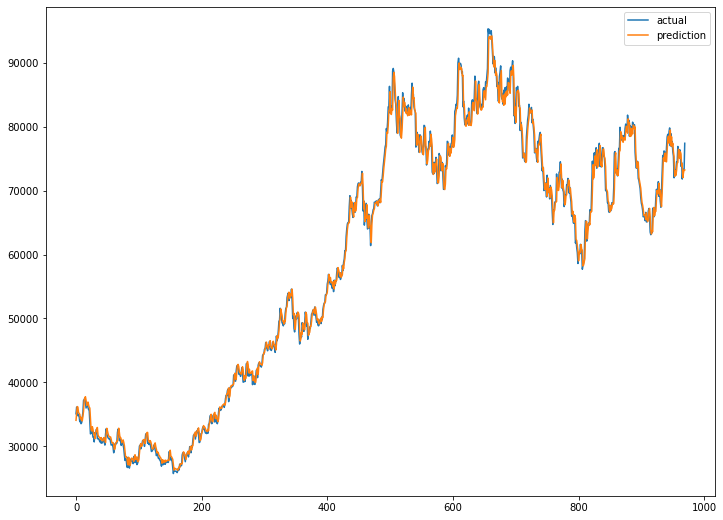

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test, label='actual')
plt.plot(closing_price, label='prediction')
plt.legend()
fig = plt.show()

# model 2
Window size = 60
Lstm(16) – Dense(1)


In [14]:
x_train_2, y_train_2 = [], []
for i in range(60,len(train)):
    x_train_2.append(scaled_data[i-60:i,0])
    y_train_2.append(scaled_data[i,0])
x_train_2, y_train_2 = np.array(x_train_2), np.array(y_train_2)

x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0],x_train_2.shape[1],1))

from sklearn.model_selection import train_test_split
x_train_2, x_valid_2, y_train_2, y_valid_2 = train_test_split(x_train_2, y_train_2, test_size=0.2,shuffle=False)
print("x_train \t y_train")
print(x_train_2.shape, y_train_2.shape)
print("x_valid \t y_valid")
print(x_valid_2.shape, y_valid_2.shape)

x_train 	 y_train
(3055, 60, 1) (3055,)
x_valid 	 y_valid
(764, 60, 1) (764,)


In [15]:
# create and fit the LSTM network
model_2 = Sequential()
model_2.add(LSTM(units=16, return_sequences=False, input_shape=(x_train_2.shape[1],1)))
model_2.add(Dense(1))
model2_path=os.getcwd()
model_2.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model2_path, 'tmp_checkpoint_2.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model_2.fit(x_train_2, y_train_2, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid_2, y_valid_2), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
189/191 [============================>.] - ETA: 0s - loss: 0.0055
Epoch 00001: val_loss improved from inf to 0.00028, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_2.h5
191/191 [==============================] - 4s 19ms/step - loss: 0.0055 - val_loss: 2.8308e-04
Epoch 2/200
189/191 [============================>.] - ETA: 0s - loss: 2.7571e-04
Epoch 00002: val_loss improved from 0.00028 to 0.00024, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_2.h5
191/191 [==============================] - 3s 17ms/step - loss: 2.7616e-04 - val_loss: 2.3640e-04
Epoch 3/200
190/191 [============================>.] - ETA: 0s - loss: 2.3899e-04
Epoch 00003: val_loss improved from 0.00024 to 0.00019, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_2.h5
191/191 [==============================] - 3s 17ms/step -

In [16]:
new = new_data[:test_start]
#predicting 246 values, using past 60 from the train data
inputs = new[len(new) - len(test) - 60:].values
# 여기사 test(valid)는 new_data.values[987:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model_2.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [17]:
rms=np.sqrt(np.mean(np.power((test-closing_price),2)))
print("RMSE: ", rms)
mape = 100 * np.mean(np.abs((test-closing_price) / test))
print("MAPE: ", mape)

RMSE:  1476.528097825081
MAPE:  1.8413499929581114


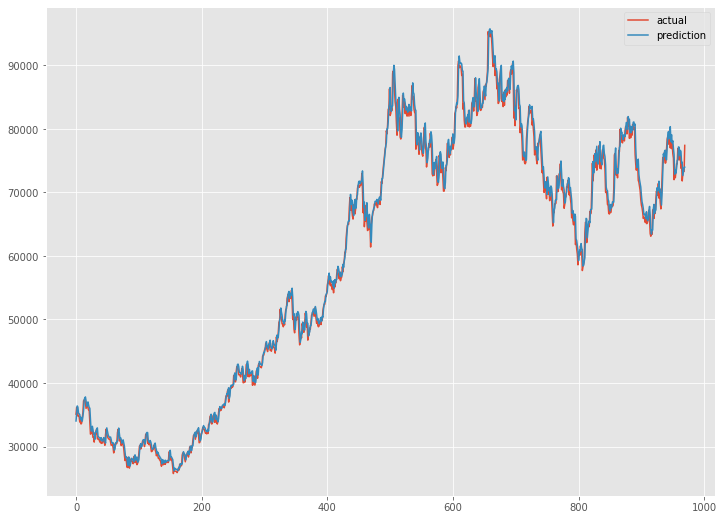

In [18]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
plt.style.use('ggplot')

plt.figure(figsize=(12, 9))
plt.plot(test, label='actual')
plt.plot(closing_price, label='prediction')
plt.legend()
fig = plt.show()

#model 3


In [ ]:
x_train_3, y_train_3 = [], []
for i in range(20,len(train)):
    x_train_3.append(scaled_data[i-20:i,0])
    y_train_3.append(scaled_data[i,0])
x_train_3, y_train_3 = np.array(x_train_3), np.array(y_train_3)

x_train_3 = np.reshape(x_train_3, (x_train_3.shape[0],x_train_3.shape[1],1))

x_train_3, x_valid_3, y_train_3, y_valid_3 = train_test_split(x_train_3, y_train_3, test_size=0.2, shuffle=False)
print("x_train \t y_train")
print(x_train_3.shape, y_train_3.shape)
print("x_valid \t y_valid")
print(x_valid_3.shape, y_valid_3.shape)

x_train 	 y_train
(3087, 20, 1) (3087,)
x_valid 	 y_valid
(772, 20, 1) (772,)


In [ ]:
# create and fit the LSTM network
model_3 = Sequential()
model_3.add(LSTM(units=16, return_sequences=True, input_shape=(x_train_3.shape[1],1)))
model_3.add(LSTM(16))
model_3.add(Dense(1))
model3_path=os.getcwd()
model_3.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model3_path, 'tmp_checkpoint_3.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model_3.fit(x_train_3, y_train_3, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid_3, y_valid_3), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
191/193 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00001: val_loss improved from inf to 0.00023, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_3.h5
193/193 [==============================] - 4s 23ms/step - loss: 0.0022 - val_loss: 2.2675e-04
Epoch 2/200
190/193 [============================>.] - ETA: 0s - loss: 2.3727e-04
Epoch 00002: val_loss improved from 0.00023 to 0.00022, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_3.h5
193/193 [==============================] - 3s 14ms/step - loss: 2.3755e-04 - val_loss: 2.1677e-04
Epoch 3/200
191/193 [============================>.] - ETA: 0s - loss: 2.2126e-04
Epoch 00003: val_loss did not improve from 0.00022
193/193 [==============================] - 3s 14ms/step - loss: 2.2154e-04 - val_loss: 2.5284e-04
Epoch 4/200
191/193 [============================>.] - ETA: 0s - loss: 2.1359e-

In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new[len(new) - len(test) - 20:].values
# 여기사 test(valid)는 new_data.values[987:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(20,inputs.shape[0]):
    X_test.append(inputs[i-20:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model_3.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
rms=np.sqrt(np.mean(np.power((test-closing_price),2)))
print("RMSE: ", rms)
mape = 100 * np.mean(np.abs((test-closing_price) / test))
print("MAPE: ", mape)

RMSE:  1823.4186124528364
MAPE:  2.125875402037818


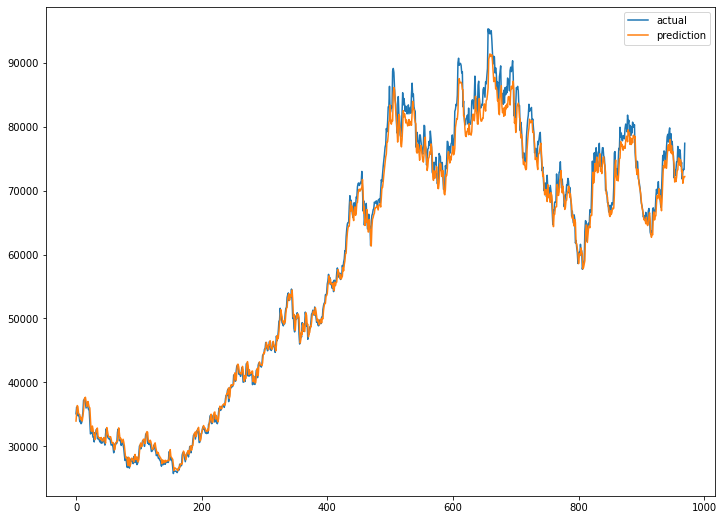

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test, label='actual')
plt.plot(closing_price, label='prediction')
plt.legend()
fig = plt.show()

#model 4
window size = 20
LSTM(50) - LSTM(50) - Dense(1)

In [ ]:
x_train_4, y_train_4 = [], []
for i in range(20,len(train)):
    x_train_4.append(scaled_data[i-20:i,0])
    y_train_4.append(scaled_data[i,0])
x_train_4, y_train_4 = np.array(x_train_4), np.array(y_train_4)

x_train_4 = np.reshape(x_train_4, (x_train_4.shape[0],x_train_4.shape[1],1))

x_train_4, x_valid_4, y_train_4, y_valid_4 = train_test_split(x_train_4, y_train_4, test_size=0.2,shuffle=False)
print("x_train \t y_train")
print(x_train_4.shape, y_train_4.shape)
print("x_valid \t y_valid")
print(x_valid_4.shape, y_valid_4.shape)

x_train 	 y_train
(3087, 20, 1) (3087,)
x_valid 	 y_valid
(772, 20, 1) (772,)


In [ ]:
# create and fit the LSTM network
model_4 = Sequential()
model_4.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_4.shape[1],1)))
model_4.add(LSTM(50))
model_4.add(Dense(1))
model4_path=os.getcwd()
model_4.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model4_path, 'tmp_checkpoint_4.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model_4.fit(x_train_4, y_train_4, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid_4, y_valid_4), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
192/193 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00001: val_loss improved from inf to 0.00022, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_4.h5
193/193 [==============================] - 4s 21ms/step - loss: 0.0015 - val_loss: 2.1519e-04
Epoch 2/200
191/193 [============================>.] - ETA: 0s - loss: 2.0381e-04
Epoch 00002: val_loss did not improve from 0.00022
193/193 [==============================] - 3s 17ms/step - loss: 2.0219e-04 - val_loss: 2.1782e-04
Epoch 3/200
192/193 [============================>.] - ETA: 0s - loss: 1.7950e-04
Epoch 00003: val_loss did not improve from 0.00022
193/193 [==============================] - 3s 17ms/step - loss: 1.7944e-04 - val_loss: 2.6137e-04
Epoch 4/200
191/193 [============================>.] - ETA: 0s - loss: 1.7131e-04
Epoch 00004: val_loss improved from 0.00022 to 0.00017, saving model to /content/drive/.shortcut-targets-by-id/1t6-0B

In [ ]:
closing_price = model_4.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
rms=np.sqrt(np.mean(np.power((test-closing_price),2)))
print("RMSE: ", rms)
mape = 100 * np.mean(np.abs((test-closing_price) / test))
print("MAPE: ", mape)

RMSE:  1665.021040510825
MAPE:  1.9657217631418076


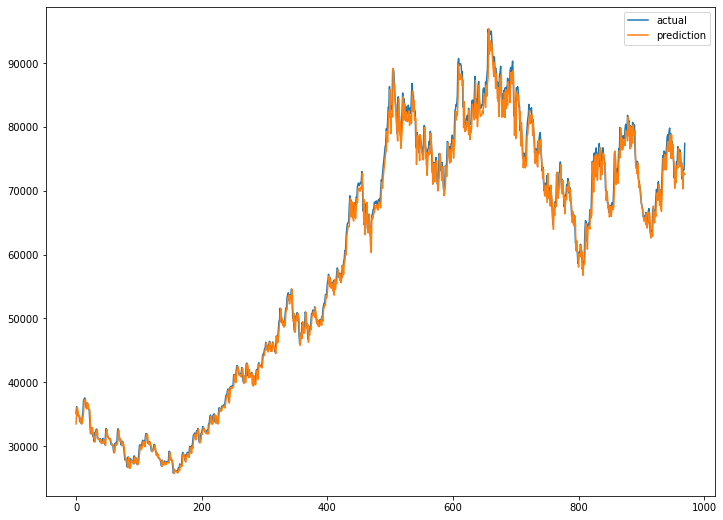

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test, label='actual')
plt.plot(closing_price, label='prediction')
plt.legend()
fig = plt.show()

#model 5
Bidirectional LSTM

In [ ]:
x_train_5, y_train_5 = [], []
for i in range(20,len(train)):
    x_train_5.append(scaled_data[i-20:i,0])
    y_train_5.append(scaled_data[i,0])
x_train_5, y_train_5 = np.array(x_train_5), np.array(y_train_5)

x_train_5 = np.reshape(x_train_5, (x_train_5.shape[0],x_train_5.shape[1],1))

x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(x_train_5, y_train_5, test_size=0.2,shuffle=False)
print("x_train \t y_train")
print(x_train_5.shape, y_train_5.shape)
print("x_valid \t y_valid")
print(x_valid_5.shape, y_valid_5.shape)

x_train 	 y_train
(3087, 20, 1) (3087,)
x_valid 	 y_valid
(772, 20, 1) (772,)


In [ ]:
from keras.layers import Bidirectional
# create and fit the LSTM network
model_5 = Sequential()
model_5.add(Bidirectional(LSTM(units=50, 
                               activation='relu',
                               return_sequences=False, 
                               input_shape=(x_train_5.shape[1],1))
          ))
model_5.add(Dense(1))
model5_path=os.getcwd()
model_5.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model5_path, 'tmp_checkpoint_5.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model_5.fit(x_train_5, y_train_5, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid_5, y_valid_5), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
190/193 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 00001: val_loss improved from inf to 0.00025, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_5.h5
193/193 [==============================] - 3s 15ms/step - loss: 0.0036 - val_loss: 2.4888e-04
Epoch 2/200
192/193 [============================>.] - ETA: 0s - loss: 2.7543e-04
Epoch 00002: val_loss improved from 0.00025 to 0.00024, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_5.h5
193/193 [==============================] - 3s 13ms/step - loss: 2.7504e-04 - val_loss: 2.4160e-04
Epoch 3/200
190/193 [============================>.] - ETA: 0s - loss: 2.7839e-04
Epoch 00003: val_loss improved from 0.00024 to 0.00021, saving model to /content/drive/.shortcut-targets-by-id/1t6-0BUco9HRnHygsMqUj5ICBmose6jur/서영/tmp_checkpoint_5.h5
193/193 [==============================] - 3s 14ms/step -

In [ ]:
closing_price = model_5.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
rms=np.sqrt(np.mean(np.power((test-closing_price),2)))
print("RMSE: ", rms)
mape = 100 * np.mean(np.abs((test-closing_price) / test))
print("MAPE: ", mape)

RMSE:  1697.8539409864538
MAPE:  2.02968328793678


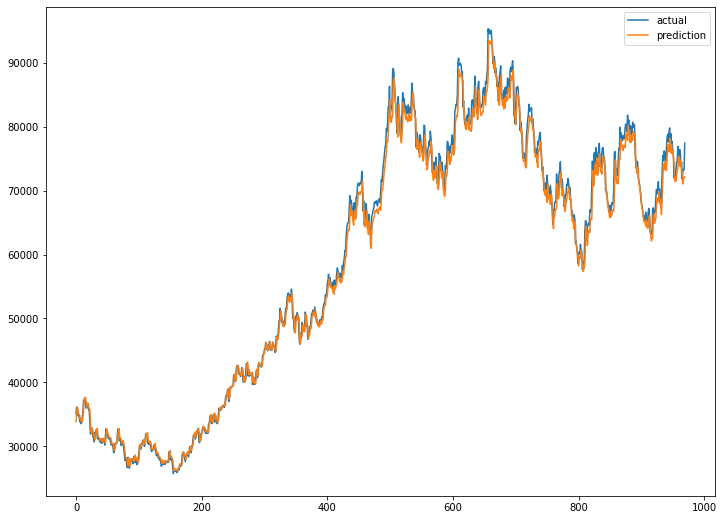

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test, label='actual')
plt.plot(closing_price, label='prediction')
plt.legend()
fig = plt.show()